In [1]:
import numpy as np
import scipy as sc
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from matplotlib.ticker import MultipleLocator

In [2]:
# Open the netCDF file and extract the sst variable
dm = nc.Dataset('ncon.nc')
ds = nc.Dataset('nsst.nc')
mfc = dm.variables['NMFC'][:,15:22,50:81]
sst = ds.variables['NSST'][:,15:22,50:81]
lon = ds.variables['XA'][50:81]
lat = ds.variables['YA'][15:22]
time = ds.variables['TIME1']

In [3]:
# Reshape the sst array into a 2D array
sst_2d = sst.reshape(sst.shape[0], -1)
mfc_2d = mfc.reshape(mfc.shape[0], -1)
sst_2d.shape

(40, 217)

In [4]:
# Create a list of times and locations for sst
times = np.arange(sst.shape[0])
lons, lats = np.meshgrid(ds.variables['XA'][50:81], ds.variables['YA'][15:22])
locations = [(lon, lat) for lon, lat in zip(lons.flatten(), lats.flatten())]

In [5]:
# Create a pandas DataFrame with the reshaped sst data
dfs = pd.DataFrame(data=sst_2d, index=times, columns=locations)
#dfs.to_csv('nsst.csv')

In [6]:
# Create a pandas DataFrame with the reshaped sst data
dfs = pd.DataFrame(data=sst_2d, index=times, columns=locations)
dfs.shape

(40, 217)

In [7]:
dfm = pd.DataFrame(data=mfc_2d, index=times, columns=locations)
dfm.shape

(40, 217)

In [8]:
# Drop columns containing no values for sst
dfs.dropna(axis=1, how='all', inplace=True)
print('Dimension of modified sst array ; ',dfs.shape)
#Save the modified DataFrame to a CSV file
#dfs.to_csv('modified_sst_2d_array.csv')

Dimension of modified sst array ;  (40, 214)


In [9]:
# Convert the DataFrame to a NumPy array
ds1_array = dfs.to_numpy()
dm1_array = dfm.to_numpy()

In [10]:
# shape of new numpy array
print(ds1_array.shape)
print(dm1_array.shape)

(40, 214)
(40, 217)


In [11]:
# detrend the data
ds1_array = sc.signal.detrend(ds1_array.T, type='constant')
ds1_array = ds1_array.T
print('Dimension of modified sst array :', ds1_array.shape)

dm1_array = sc.signal.detrend(dm1_array.T, type='constant')
dm1_array = dm1_array.T
print('Dimension of modified mfc array :', dm1_array.shape)

Dimension of modified sst array : (40, 214)
Dimension of modified mfc array : (40, 217)


In [12]:
# covariance matrix
c = ds1_array.T.dot(dm1_array) # sst x mfc
print('Dimension Of Covariance Matrix :', c.shape)

Dimension Of Covariance Matrix : (214, 217)


In [13]:
# perform svd
u, s, vt = np.linalg.svd(c,full_matrices=True)
print('shape of u', u.shape)
print('shape of s', s.shape)
print('shape of vt', vt.shape)

shape of u (214, 214)
shape of s (214,)
shape of vt (217, 217)


In [14]:
#u = u*-1

In [15]:
# Calculate SCF for each mode
SCF = (s**2) / np.sum(s**2)

In [16]:
#vt = vt*-1

In [17]:
# Expansion Coefficients
a = ds1_array.dot(u) # sst
b = dm1_array.dot(vt)*10E7 # mfc
T = np.linspace(1980,2020,40)

In [18]:
a1 = sc.signal.detrend(a)

In [19]:
# Extract the first three expansion coefficients of SST and MFC
a_first_three = a[:, 0]
b_first_three = b[:, 0]

# Calculate the correlation matrix
corr_coef = np.corrcoef((a_first_three.T), (b_first_three.T))
mode_index = 1
print(f"Mode {mode_index}: SCF={SCF[0]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")
#detrended
corr_coef = np.corrcoef(sc.signal.detrend(a_first_three.T), sc.signal.detrend(b_first_three.T))
print(f"Mode {mode_index} detrended: SCF={SCF[0]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")

Mode 1: SCF=96.68%, corr_coef=-0.35
Mode 1 detrended: SCF=96.68%, corr_coef=-0.30


In [20]:
# Extract the first three expansion coefficients of SST and MFC
a_first_three = a[:, 1:2]
b_first_three = b[:, 1:2]

# Calculate the correlation matrix
corr_coef = np.corrcoef((a_first_three.T), (b_first_three.T))
mode_index = 2
print(f"Mode {mode_index}: SCF={SCF[1]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")
#detrended
corr_coef = np.corrcoef(sc.signal.detrend(a_first_three.T), sc.signal.detrend(b_first_three.T))
print(f"Mode {mode_index} detrended: SCF={SCF[1]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")

Mode 2: SCF=1.99%, corr_coef=0.45
Mode 2 detrended: SCF=1.99%, corr_coef=0.47


In [21]:
# Extract the first three expansion coefficients of SST and MFC
a_first_three = a[:, 2:3]
b_first_three = b[:, 2:3]

# Calculate the correlation matrix
corr_coef = np.corrcoef((a_first_three.T), (b_first_three.T))
mode_index = 3
print(f"Mode {mode_index}: SCF={SCF[2]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")
#detrended
corr_coef = np.corrcoef(sc.signal.detrend(a_first_three.T), sc.signal.detrend(b_first_three.T))
print(f"Mode {mode_index} detrended: SCF={SCF[2]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")

Mode 3: SCF=0.75%, corr_coef=-0.30
Mode 3 detrended: SCF=0.75%, corr_coef=-0.26


In [22]:
# expansion coefficients of SST and MFC year 1980 - 1999
a_first_three = a[:18, 0]
b_first_three = b[:18, 0]

# Calculate the correlation matrix
corr_coef = np.corrcoef((a_first_three.T), (b_first_three.T))
mode_index = 1
print(f"Mode {mode_index}: SCF={SCF[0]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")
#detrended
corr_coef = np.corrcoef(sc.signal.detrend(a_first_three.T), sc.signal.detrend(b_first_three.T))
print(f"Mode {mode_index} detrended: SCF={SCF[0]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")

Mode 1: SCF=96.68%, corr_coef=-0.51
Mode 1 detrended: SCF=96.68%, corr_coef=-0.51


In [23]:
# Extract the first three expansion coefficients of SST and MFC year 2000 - 2020
a_first_three = a[19:, 0]
b_first_three = b[19:, 0]

# Calculate the correlation matrix
corr_coef = np.corrcoef((a_first_three.T), (b_first_three.T))
mode_index = 1
print(f"Mode {mode_index}: SCF={SCF[0]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")
#detrended
corr_coef = np.corrcoef(sc.signal.detrend(a_first_three.T), sc.signal.detrend(b_first_three.T))
print(f"Mode {mode_index} detrended: SCF={SCF[0]*100:.2f}%, corr_coef={corr_coef[0,1]:.2f}")

Mode 1: SCF=96.68%, corr_coef=-0.32
Mode 1 detrended: SCF=96.68%, corr_coef=-0.12


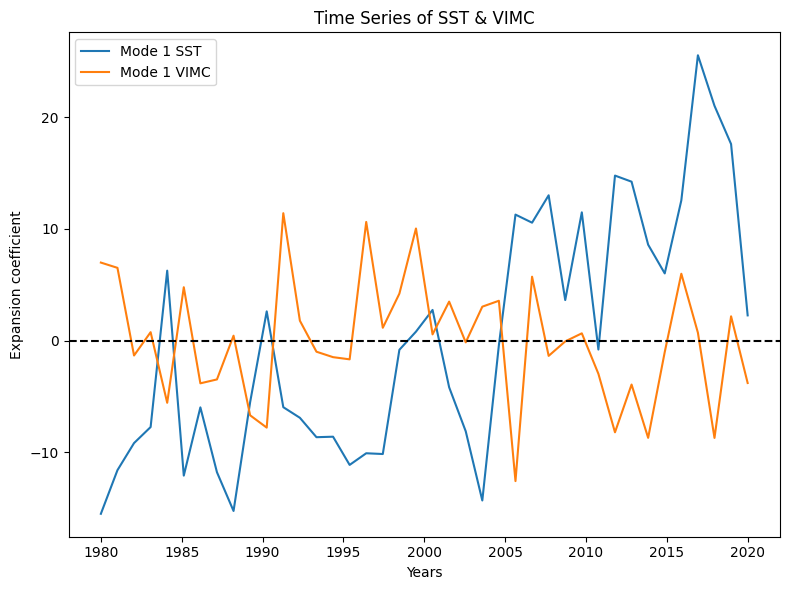

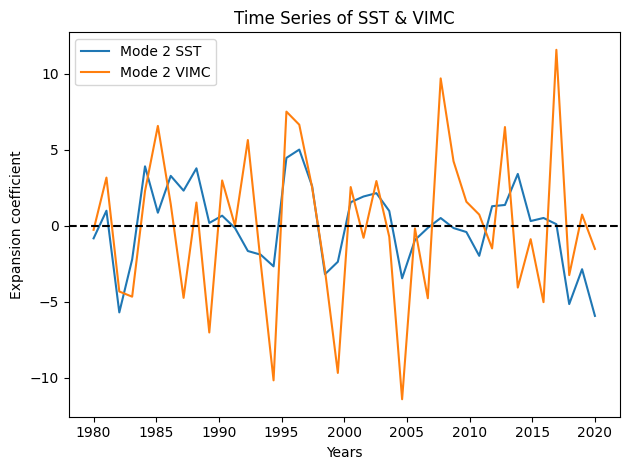

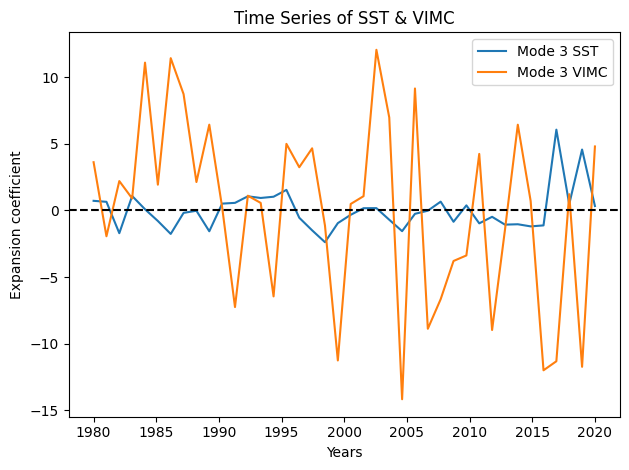

In [24]:
# plot
fig = plt.figure(figsize=(8, 6))

# Plot the expansion coefficients for the first three modes
for i in range(3):
    plt.plot(T, a[:, i], label=f'Mode {i+1} SST')
    plt.plot(T, b[:, i], label=f'Mode {i+1} VIMC')
    plt.axhline(y=0, color='black', linestyle='--')

    # Add labels and legend
    plt.xlabel('Years')
    plt.ylabel('Expansion coefficient')
    plt.title('Time Series of SST & VIMC')
    plt.legend()

    # Save and show the figure
    plt.tight_layout()
    #plt.savefig(f'TS_mode_{i+1}.png', dpi=300)
    plt.show()


In [25]:
u = u.T

In [26]:
# Create a pandas DataFrame with the reshaped sst data
dfs = pd.DataFrame(data=sst_2d, index=times, columns=locations)
dfs.shape

(40, 217)

In [27]:
# Get the list of columns with NaN values
nan_columns = dfs.columns[dfs.isna().any()].tolist()
print(len(nan_columns))

3


In [28]:
# Get the index values of the columns that contain NaN values
nan_column_indices = dfs.columns.get_indexer(nan_columns)
nan_column_indices

array([140, 141, 142])

In [29]:
c=np.nan

In [30]:
u = u.astype(float)

In [31]:
# reshaping sst array 3404x4681
for x in nan_column_indices:
    u = np.insert(u, x, c, axis=1)
u.shape

(214, 217)

In [43]:
print(len(u[0]))

217


/home/rahul/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/rahul/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/rahul/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


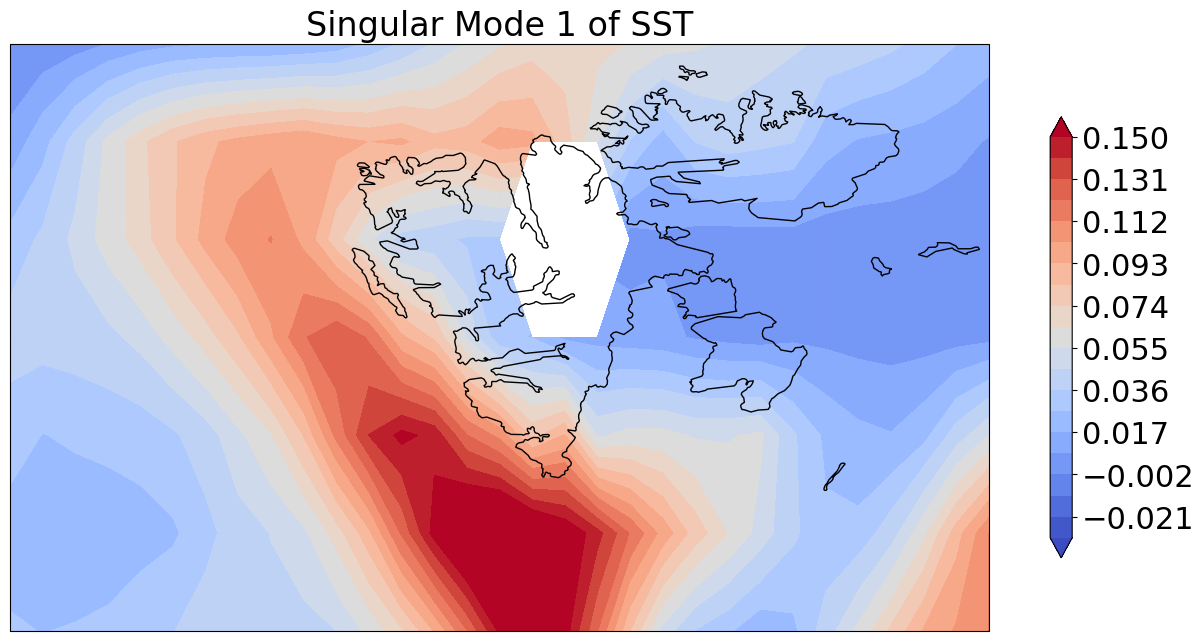

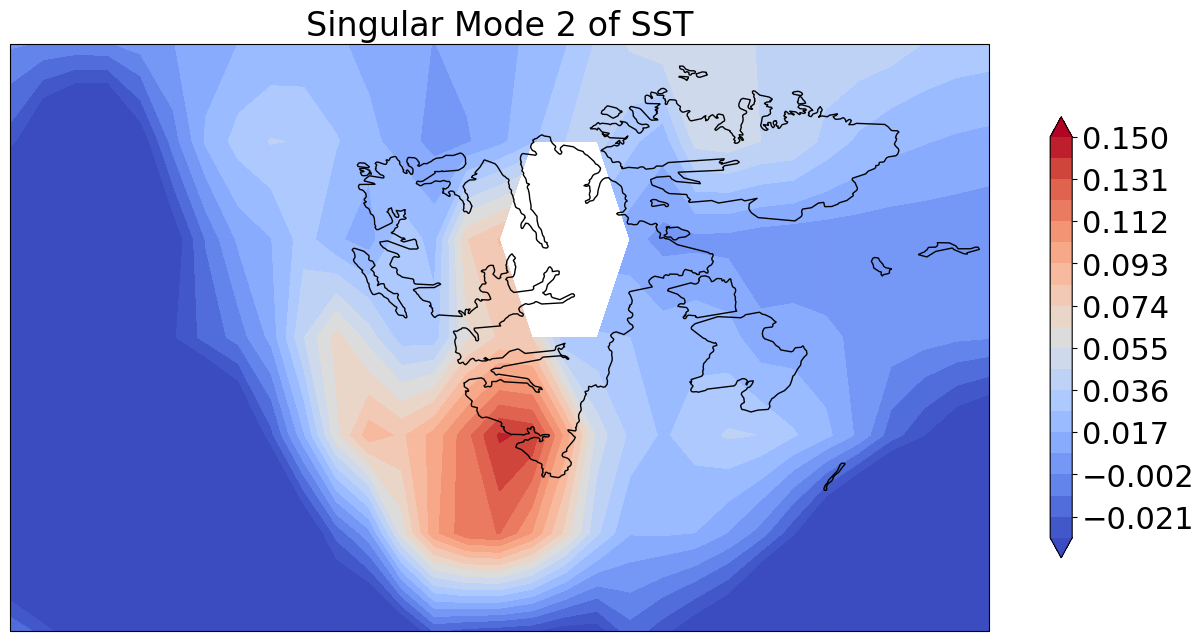

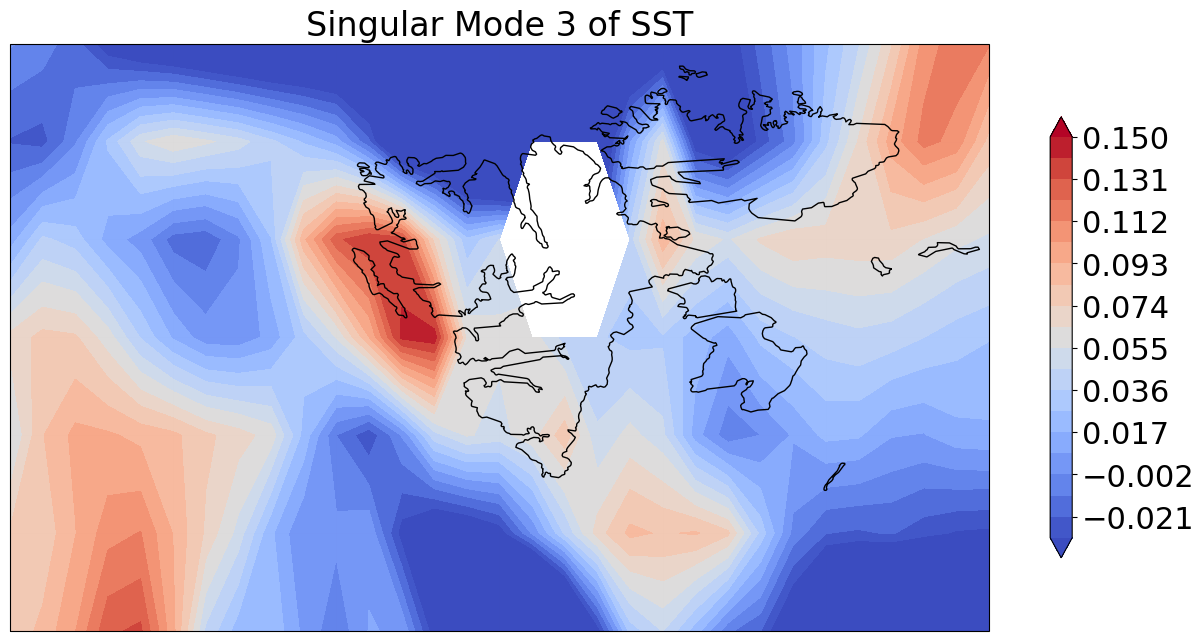

In [32]:
levels = np.round(np.linspace(-0.03, 0.15, 20),3)
for i in range(3):
    sst_mode = u[i].reshape(sst.shape[1], sst.shape[2])  # shape: (lat, lon)

    # Plot the singular modes as contour maps with land
    fig = plt.figure(figsize=(25,15))

    # Plot sst_mode
    ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
    ax2.set_extent([dm.variables["XA"][50:81].min(), dm.variables["XA"][50:81].max(),
                    dm.variables["YA"][15:22].min(), dm.variables["YA"][15:22].max()], crs=ccrs.PlateCarree())
    ax2.coastlines()
    cf = ax2.contourf(dm.variables["XA"][50:81], dm.variables["YA"][15:22], sst_mode, levels=levels,
                      transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')

    # Overlay contours of SLP anomaly
    #contour = ax2.contour(dslp_average_slp1.XA, dslp_average_slp1.YA, dslp_average_slp1, colors='k', levels=levels1)
    #ax2.clabel(contour, inline=True, fontsize=8)

    ax2.set_title(f'Singular Mode {i+1} of SST',fontsize=24)
    #Add colorbar with label
    cbar = plt.colorbar(cf, shrink=0.30, pad=0.05)
    #cbar.set_label('Structures', fontsize=12)  # Add label to colorbar
    cbar.ax.tick_params(labelsize=22)
   
    # Add longitude and latitude gridlines
    gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, color='gray', alpha=0.005, linestyle='-')
    
    #ax2.quiver(lon[::5], lat[::5], uwnd_avg[::5, ::5], vwnd_avg[::5, ::5],
              # transform=ccrs.PlateCarree(), angles='xy', scale=110000, alpha=0.9)

    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 9, 'color': 'black'}
    gl.ylabel_style = {'size': 9, 'color': 'black'}

    ax2.set_aspect(3)
    plt.tight_layout()
    #plt.savefig(f'Singular_Mode_{i+1}_of_SST_VIMC.png',dpi=400)
    plt.show()


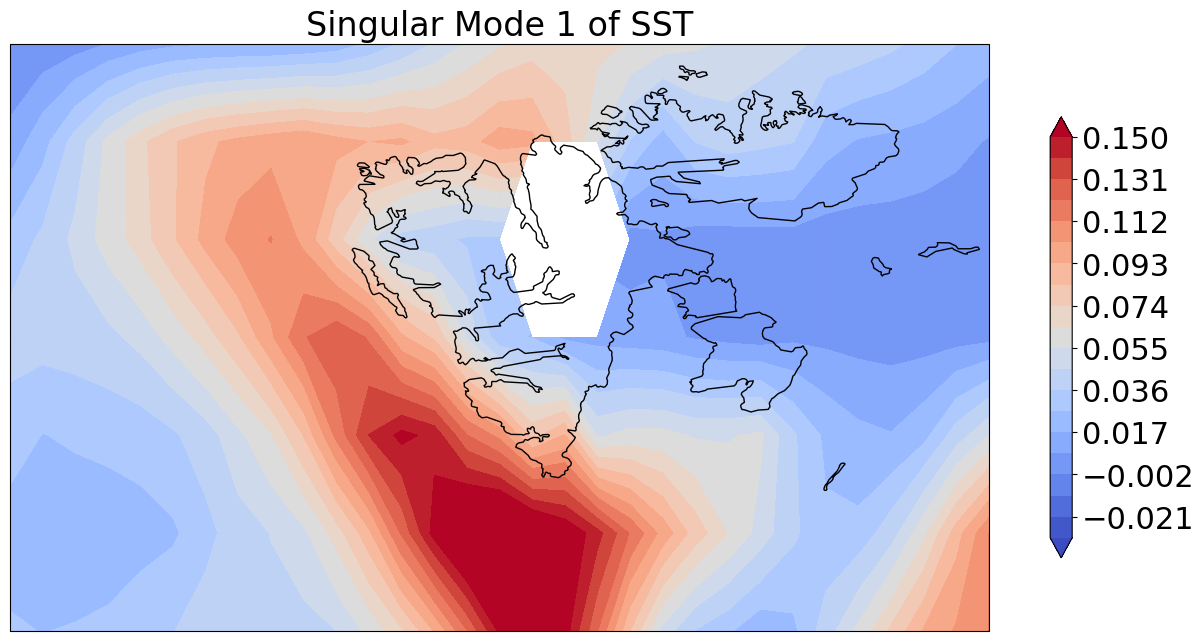

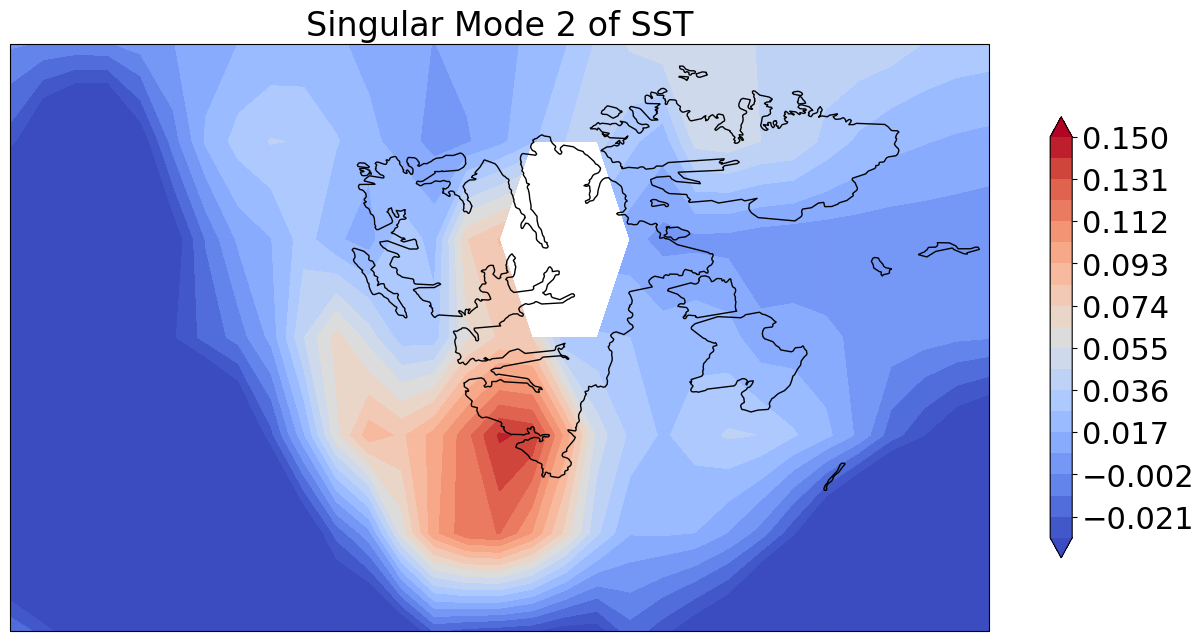

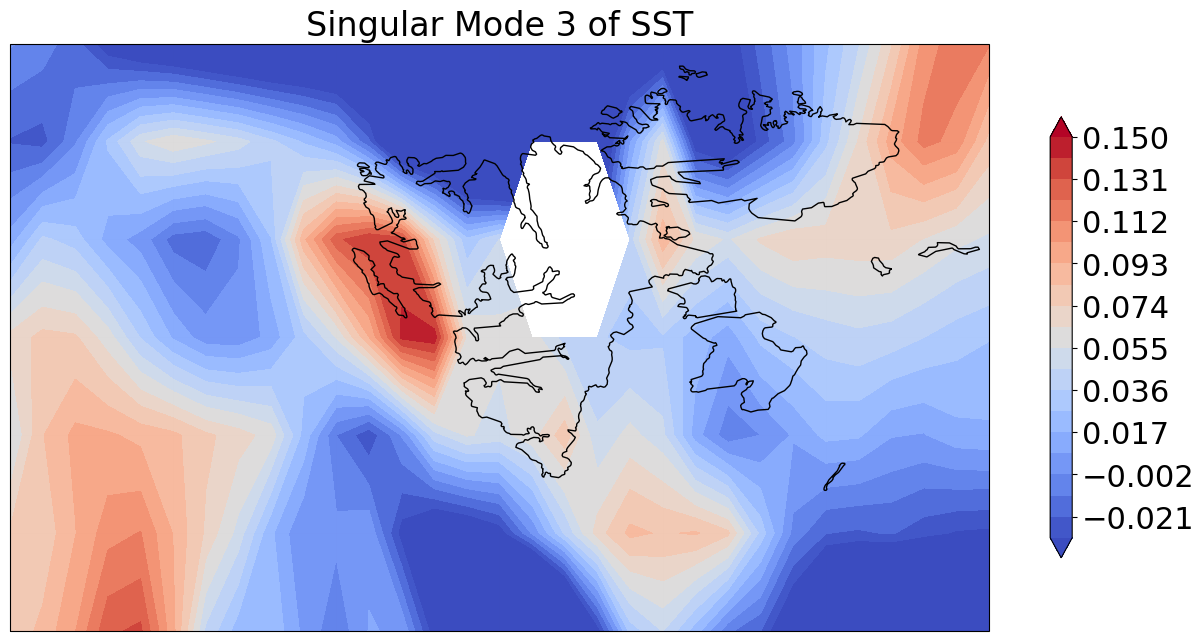

In [41]:
levels = np.round(np.linspace(-0.03, 0.15, 20),3)
for i in range(3):
    sst_mode = u[i].reshape(sst.shape[1], sst.shape[2])  # shape: (lat, lon)

    # Apply a mask for land areas
    mask = np.isnan(sst_mode)
    sst_mode = np.ma.masked_where(mask, sst_mode)

    # Plot the singular modes as contour maps with land
    fig = plt.figure(figsize=(25,15))

    # Plot sst_mode
    ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
    ax2.set_extent([dm.variables["XA"][50:81].min(), dm.variables["XA"][50:81].max(),
                    dm.variables["YA"][15:22].min(), dm.variables["YA"][15:22].max()], crs=ccrs.PlateCarree())
    ax2.coastlines()
    cf = ax2.contourf(dm.variables["XA"][50:81], dm.variables["YA"][15:22], sst_mode, levels=levels,
                      transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')

    # Overlay contours of SLP anomaly
    #contour = ax2.contour(dslp_average_slp1.XA, dslp_average_slp1.YA, dslp_average_slp1, colors='k', levels=levels1)
    #ax2.clabel(contour, inline=True, fontsize=8)

    ax2.set_title(f'Singular Mode {i+1} of SST',fontsize=24)
    #Add colorbar with label
    cbar = plt.colorbar(cf, shrink=0.30, pad=0.05)
    #cbar.set_label('Structures', fontsize=12)  # Add label to colorbar
    cbar.ax.tick_params(labelsize=22)
   
    # Add longitude and latitude gridlines
    gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, color='gray', alpha=0.005, linestyle='-')
    
    #ax2.quiver(lon[::5], lat[::5], uwnd_avg[::5, ::5], vwnd_avg[::5, ::5],
              # transform=ccrs.PlateCarree(), angles='xy', scale=110000, alpha=0.9)

    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 9, 'color': 'black'}
    gl.ylabel_style = {'size': 9, 'color': 'black'}

    ax2.set_aspect(3)
    plt.tight_layout()
    #plt.savefig(f'Singular_Mode_{i+1}_of_SST_VIMC.png',dpi=400)
    plt.show()


In [33]:
vt = vt*-1

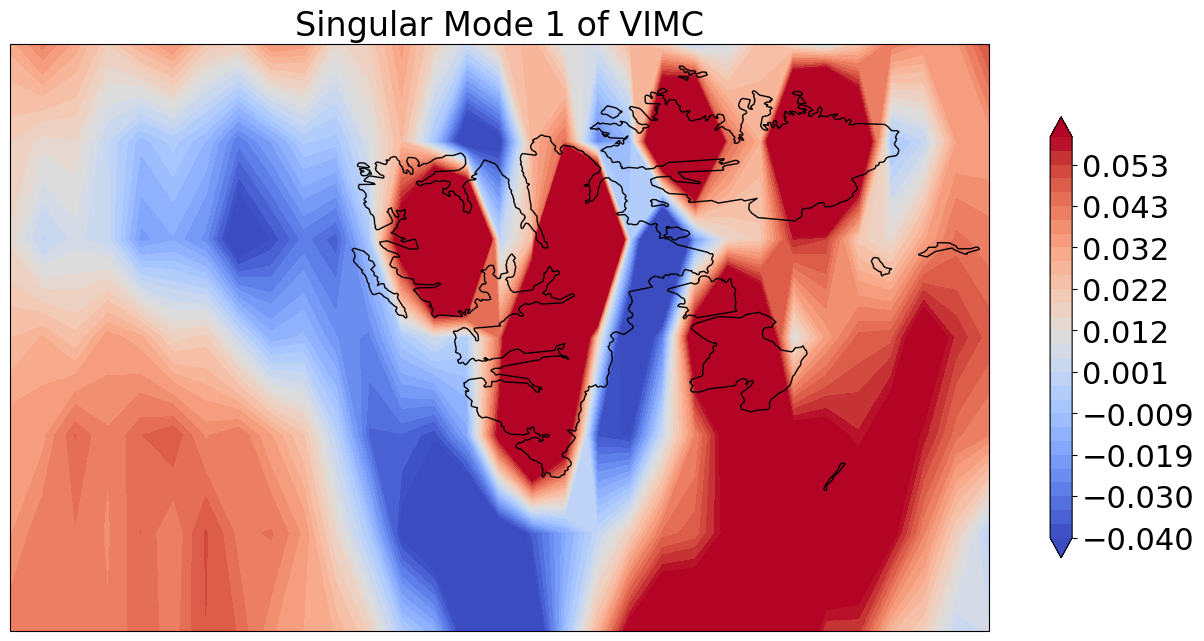

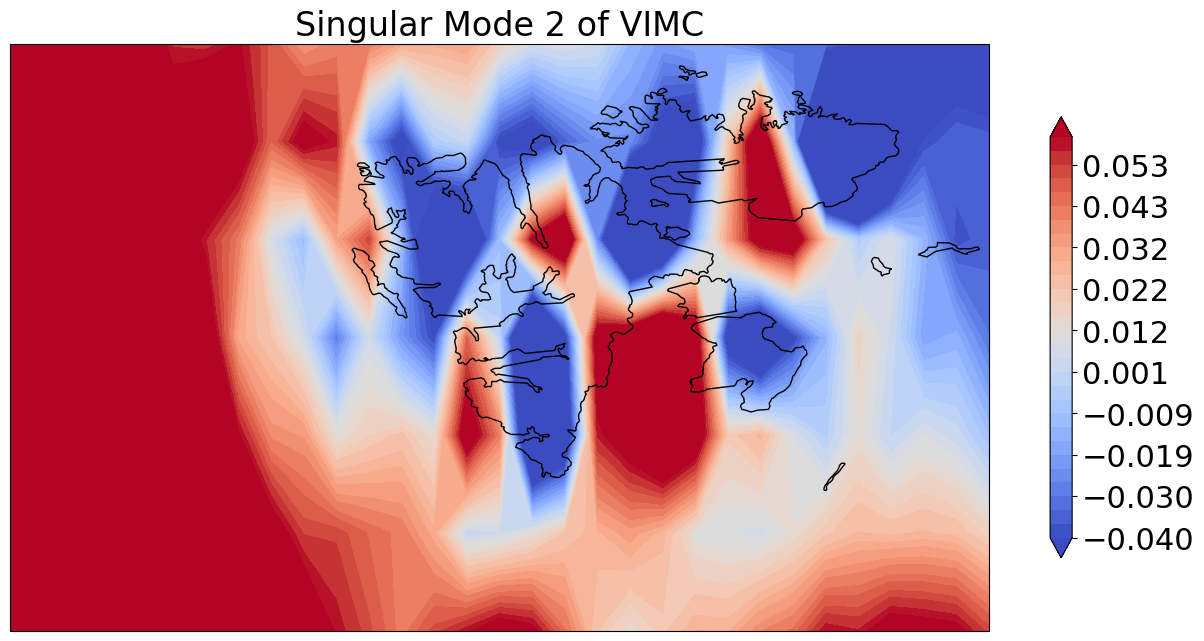

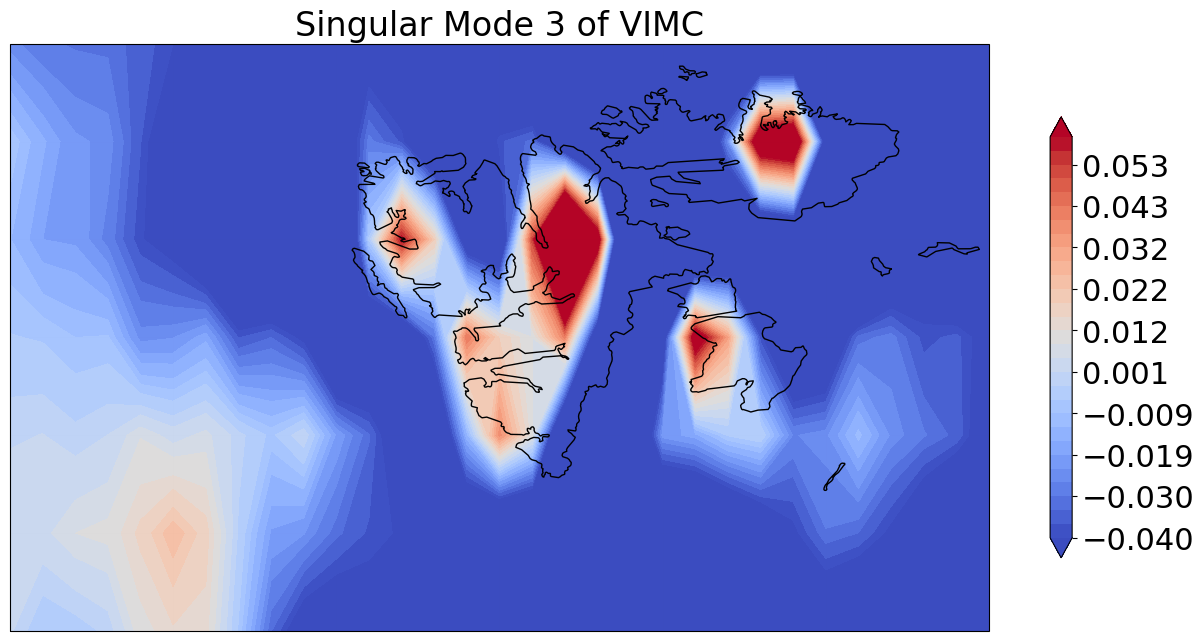

In [34]:
levels = np.round(np.linspace(-0.04, 0.06, 30),3)
for i in range(3):
    sst_mode = vt[i].reshape(sst.shape[1], sst.shape[2])  # shape: (lat, lon)

    # Plot the singular modes as contour maps with land
    fig = plt.figure(figsize=(25,15))

    # Plot sst_mode
    ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
    ax2.set_extent([dm.variables["XA"][50:81].min(), dm.variables["XA"][50:81].max(),
                    dm.variables["YA"][15:22].min(), dm.variables["YA"][15:22].max()], crs=ccrs.PlateCarree())
    ax2.coastlines()
    cf = ax2.contourf(dm.variables["XA"][50:81], dm.variables["YA"][15:22], sst_mode, levels=levels,
                      transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')

    # Overlay contours of SLP anomaly
    #contour = ax2.contour(dslp_average_slp1.XA, dslp_average_slp1.YA, dslp_average_slp1, colors='k', levels=levels1)
    #ax2.clabel(contour, inline=True, fontsize=8)

    ax2.set_title(f'Singular Mode {i+1} of VIMC',fontsize=24)
    #Add colorbar with label
    cbar = plt.colorbar(cf, shrink=0.30, pad=0.05)
   # cbar.set_label('Structures', fontsize=12)  # Add label to colorbar
    cbar.ax.tick_params(labelsize=22)
   
    # Add longitude and latitude gridlines
    gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, color='gray', alpha=0.005, linestyle='-')
    
    #ax2.quiver(lon[::5], lat[::5], uwnd_avg[::5, ::5], vwnd_avg[::5, ::5],
              # transform=ccrs.PlateCarree(), angles='xy', scale=110000, alpha=0.9)

    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 9, 'color': 'black'}
    gl.ylabel_style = {'size': 9, 'color': 'black'}

    ax2.set_aspect(3)
    plt.tight_layout()
    #plt.savefig(f'Singular_Mode_{i+1}_of_VIMC.png',dpi=400)
    plt.show()


/home/rahul/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/rahul/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/rahul/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/rahul/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/rahul/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_

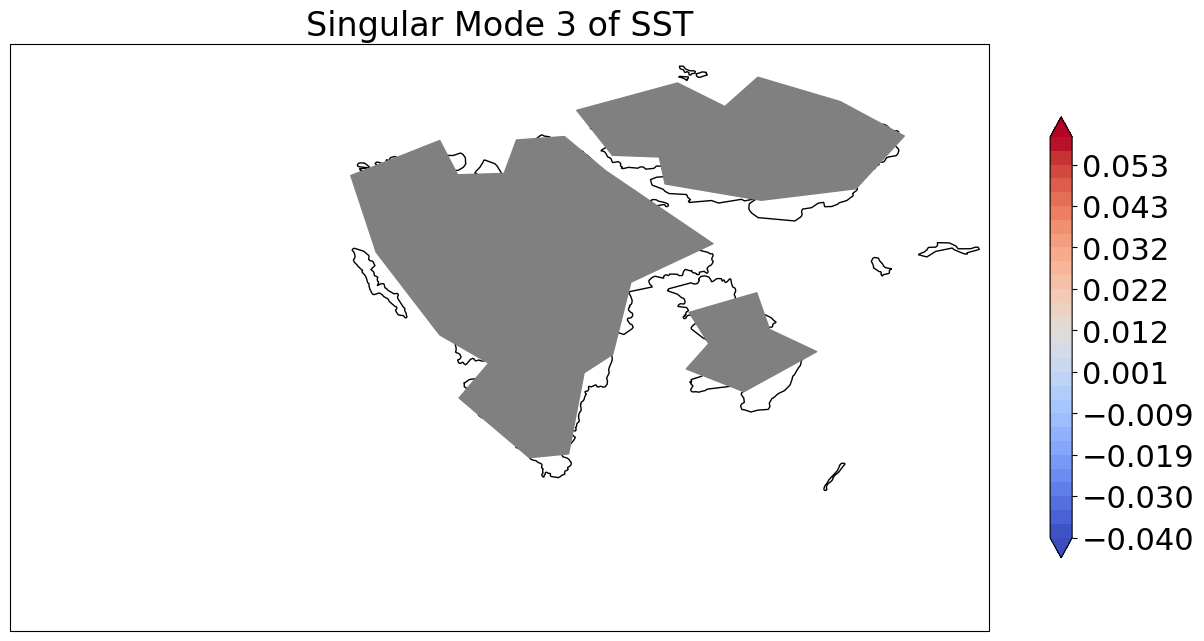

In [40]:
import cartopy.feature as cfeature
from shapely.geometry import box

# Create a Shapely polygon of the region of interest
bbox = box(dm.variables["XA"][50], dm.variables["YA"][15], dm.variables["XA"][80], dm.variables["YA"][22])

# Load the Natural Earth land feature and create a mask
land_mask = cfeature.NaturalEarthFeature('physical', 'land', '110m')
mask = np.ones(sst_mode.shape)
for geom in land_mask.geometries():
    mask = np.logical_and(mask, ~bbox.intersection(geom).is_empty)

# Apply the mask to the plot
sst_mode = np.ma.array(sst_mode, mask=mask)
fig = plt.figure(figsize=(25,15))
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
ax2.set_extent([dm.variables["XA"][50:81].min(), dm.variables["XA"][50:81].max(),
                dm.variables["YA"][15:22].min(), dm.variables["YA"][15:22].max()], crs=ccrs.PlateCarree())
ax2.coastlines()
cf = ax2.contourf(dm.variables["XA"][50:81], dm.variables["YA"][15:22], sst_mode, levels=levels,
                  transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')

# Add land-sea mask
land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face')
ax2.add_feature(land, facecolor='gray')

ax2.set_title(f'Singular Mode {i+1} of SST',fontsize=24)
cbar = plt.colorbar(cf, shrink=0.30, pad=0.05)
cbar.ax.tick_params(labelsize=22)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.005, linestyle='-')
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 9, 'color': 'black'}
gl.ylabel_style = {'size': 9, 'color': 'black'}
ax2.set_aspect(3)
plt.tight_layout()
plt.show()


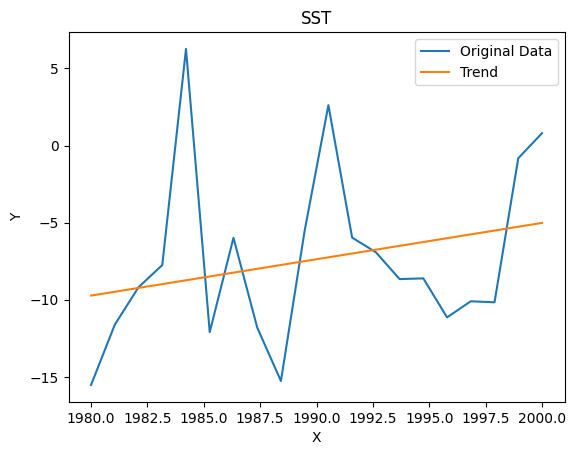

Linear Regression Coefficients:
Intercept: -476.12317048537204
Slope: 0.23555334931560776


In [35]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Generate some example data
x = np.linspace(1980, 2000, 20)
data = a[:20,0]  # Trend line: y = 2x

# Fit a linear regression model
model = LinearRegression()
X = x.reshape(-1, 1)  # Reshape x to a column vector for regression
model.fit(X, data)

# Predict the trend using the fitted model
trend = model.predict(X)

# Plot the original data and the trend
plt.plot(x, data, label='Original Data')
plt.plot(x, trend, label='Trend')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('SST')
plt.show()

# Print the coefficients of the linear regression model
print('Linear Regression Coefficients:')
print('Intercept:', model.intercept_)
print('Slope:', model.coef_[0])

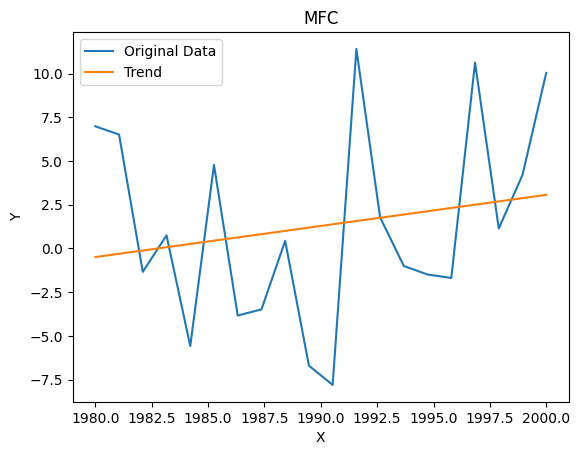

Linear Regression Coefficients:
Intercept: -352.3567181778406
Slope: 0.17771073843289362


In [36]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Generate some example data
x = np.linspace(1980, 2000,20)
data = b[:20,0]  # Trend line: y = 2x

# Fit a linear regression model
model = LinearRegression()
X = x.reshape(-1, 1)  # Reshape x to a column vector for regression
model.fit(X, data)

# Predict the trend using the fitted model
trend = model.predict(X)

# Plot the original data and the trend
plt.plot(x, data, label='Original Data')
plt.plot(x, trend, label='Trend')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('MFC')
plt.show()

# Print the coefficients of the linear regression model
print('Linear Regression Coefficients:')
print('Intercept:', model.intercept_)
print('Slope:', model.coef_[0])

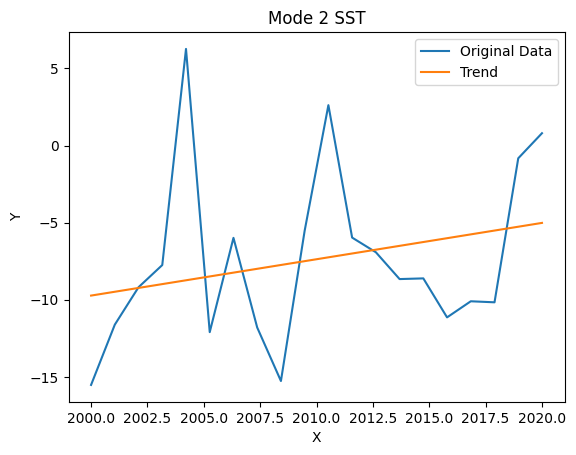

Linear Regression Coefficients:
Intercept: -480.8342374716842
Slope: 0.23555334931560776


In [37]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Generate some example data
x = np.linspace(2000, 2020, 20)
data = a[:20,0]  # Trend line: y = 2x

# Fit a linear regression model
model = LinearRegression()
X = x.reshape(-1, 1)  # Reshape x to a column vector for regression
model.fit(X, data)

# Predict the trend using the fitted model
trend = model.predict(X)

# Plot the original data and the trend
plt.plot(x, data, label='Original Data')
plt.plot(x, trend, label='Trend')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mode 2 SST')
plt.show()

# Print the coefficients of the linear regression model
print('Linear Regression Coefficients:')
print('Intercept:', model.intercept_)
print('Slope:', model.coef_[0])

In [38]:
dm = nc.Dataset('nmfc_ano_adv.nc', 'r')
mfc_2d = mfc.reshape(mfc.shape[0], -1)
times = np.arange(sst.shape[0])
lons, lats = np.meshgrid(ds.variables['XA'][:], ds.variables['YA'][:])
locations = [(lon, lat) for lon, lat in zip(lons.flatten(), lats.flatten())]
dfm = pd.DataFrame(data=mfc_2d, index=times, columns=locations)
dfm.shape

FileNotFoundError: [Errno 2] No such file or directory: b'nmfc_ano_adv.nc'

In [ ]:
import numpy as np

# Reshape the DataFrame back into the original dimension
sst_3d = dfm.values.reshape(sst.shape)

# Create a new netCDF file for saving the reshaped data
ds_out = nc.Dataset('nmfc_adv_ano.nc', 'w')

# Define the dimensions for the netCDF file
ds_out.createDimension('time', sst.shape[0])
ds_out.createDimension('latitude', sst.shape[1])
ds_out.createDimension('longitude', sst.shape[2])


# Create the variables in the netCDF file
sst_out = ds_out.createVariable('mfc', 'f4', ('time', 'latitude', 'longitude'))
longitude_out = ds_out.createVariable('longitude', 'f4', ('longitude',))
latitude_out = ds_out.createVariable('latitude', 'f4', ('latitude',))

# Define the longitude and latitude ranges
longitude = np.linspace(-50, 100, sst.shape[2])  # -50W to 100E
latitude = np.linspace(60, 90, sst.shape[1])      # 60N to 90N

# Assign the longitude and latitude values to the netCDF file
sst_out[:] = sst_3d
longitude_out[:] = longitude
latitude_out[:] = latitude

# Close the netCDF file
ds_out.close()